In [1]:
import matplotlib.pyplot as plt
import csv
import requests
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
from sklearn.cluster import KMeans
import random
import time
from scipy.spatial.distance import cdist
from collections import defaultdict

from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

In [2]:
# URLs of the CSV files on GitHub
url = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/coordinates_with_region.csv"

df = pd.read_csv(url)

# Separate data into regions
outer_points = df[df["Region"] == "outer"][["X", "Y"]].values
inner_1_points = df[df["Region"] == "inner_1"][["X", "Y"]].values
inner_2_points = df[df["Region"] == "inner_2"][["X", "Y"]].values
inner_3_points = df[df["Region"] == "inner_3"][["X", "Y"]].values

# Close shapes by adding the first point to the end
outer_points_closed = list(outer_points) + [outer_points[0]]
inner_1_points_closed = list(inner_1_points) + [inner_1_points[0]]
inner_2_points_closed = list(inner_2_points) + [inner_2_points[0]]
inner_3_points_closed = list(inner_3_points) + [inner_3_points[0]]


In [3]:
def generate_points_within_boundary(boundary, n_samples=500):
    points = []
    while len(points) < n_samples:
        x = np.random.uniform(boundary.bounds[0], boundary.bounds[2])
        y = np.random.uniform(boundary.bounds[1], boundary.bounds[3])
        point = (x, y)
        if boundary.contains(Point(point)):
            points.append(point)
    return np.array(points)

def perform_clustering(points, n_main_clusters, n_subclusters, random_state):
    kmeans_main = KMeans(n_clusters=n_main_clusters, random_state=random_state, n_init=10)
    kmeans_main.fit(points)
    cluster_labels_main = kmeans_main.labels_

    subclusters_points = []
    subclusters_labels = []
    main_labels = []
    subclusters_centroids = []
    subclusters_centroid_sub_labels = []
    subclusters_centroid_main_labels = []
    cluster_boundaries = []

    for i in range(n_main_clusters):
        main_cluster_points = points[cluster_labels_main == i]
        kmeans_sub = KMeans(n_clusters=n_subclusters, random_state=random_state, n_init=10)
        kmeans_sub.fit(main_cluster_points)
        cluster_labels_sub = kmeans_sub.labels_
        centroids_sub = kmeans_sub.cluster_centers_

        subclusters_points.extend(main_cluster_points)
        subclusters_labels.extend(cluster_labels_sub)
        main_labels.extend([i] * len(main_cluster_points))
        subclusters_centroids.extend(centroids_sub)
        subclusters_centroid_sub_labels.extend(kmeans_sub.predict(centroids_sub))
        subclusters_centroid_main_labels.extend([i] * len(centroids_sub))

        # Store cluster boundaries
        for j in range(n_subclusters):
            subcluster_points = main_cluster_points[cluster_labels_sub == j]
            if len(subcluster_points) > 2:
                cluster_boundaries.append(Polygon(subcluster_points))

    return (np.array(subclusters_points), np.array(subclusters_labels), np.array(main_labels),
            np.array(subclusters_centroids), np.array(subclusters_centroid_sub_labels),
            np.array(subclusters_centroid_main_labels), cluster_boundaries)

# Customizable cluster settings
n_main_clusters_inner_1 = 9
n_subclusters_inner_1 = 6
n_main_clusters_inner_2 = 8
n_subclusters_inner_2 = 6
n_main_clusters_inner_3 = 4
n_subclusters_inner_3 = 6
random_state = 42

# Convert inner regions into boundary polygons
inner_1_boundary = Polygon(inner_1_points)
inner_2_boundary = Polygon(inner_2_points)
inner_3_boundary = Polygon(inner_3_points)

# Generate points for each inner region
points_inner_1 = generate_points_within_boundary(inner_1_boundary, n_samples=20000)
points_inner_2 = generate_points_within_boundary(inner_2_boundary, n_samples=20000)
points_inner_3 = generate_points_within_boundary(inner_3_boundary, n_samples=20000)

# Perform clustering
subclusters_inner_1 = perform_clustering(points_inner_1, n_main_clusters_inner_1, n_subclusters_inner_1, random_state)
subclusters_inner_2 = perform_clustering(points_inner_2, n_main_clusters_inner_2, n_subclusters_inner_2, random_state)
subclusters_inner_3 = perform_clustering(points_inner_3, n_main_clusters_inner_3, n_subclusters_inner_3, random_state)

# ===== UNPACK SEMUA HASIL DARI PERFORM_CLUSTERING =====
(subclusters_points_1, subclusters_labels_1, main_labels_1,
 subclusters_centroids_1, subclusters_centroid_sub_labels_1,
 subclusters_centroid_main_labels_1, boundaries_1) = subclusters_inner_1

(subclusters_points_2, subclusters_labels_2, main_labels_2,
 subclusters_centroids_2, subclusters_centroid_sub_labels_2,
 subclusters_centroid_main_labels_2, boundaries_2) = subclusters_inner_2

(subclusters_points_3, subclusters_labels_3, main_labels_3,
 subclusters_centroids_3, subclusters_centroid_sub_labels_3,
 subclusters_centroid_main_labels_3, boundaries_3) = subclusters_inner_3



C:\Users\naufa\AppData\Local\Temp\ipykernel_17776\4233520411.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(set(main_labels)))


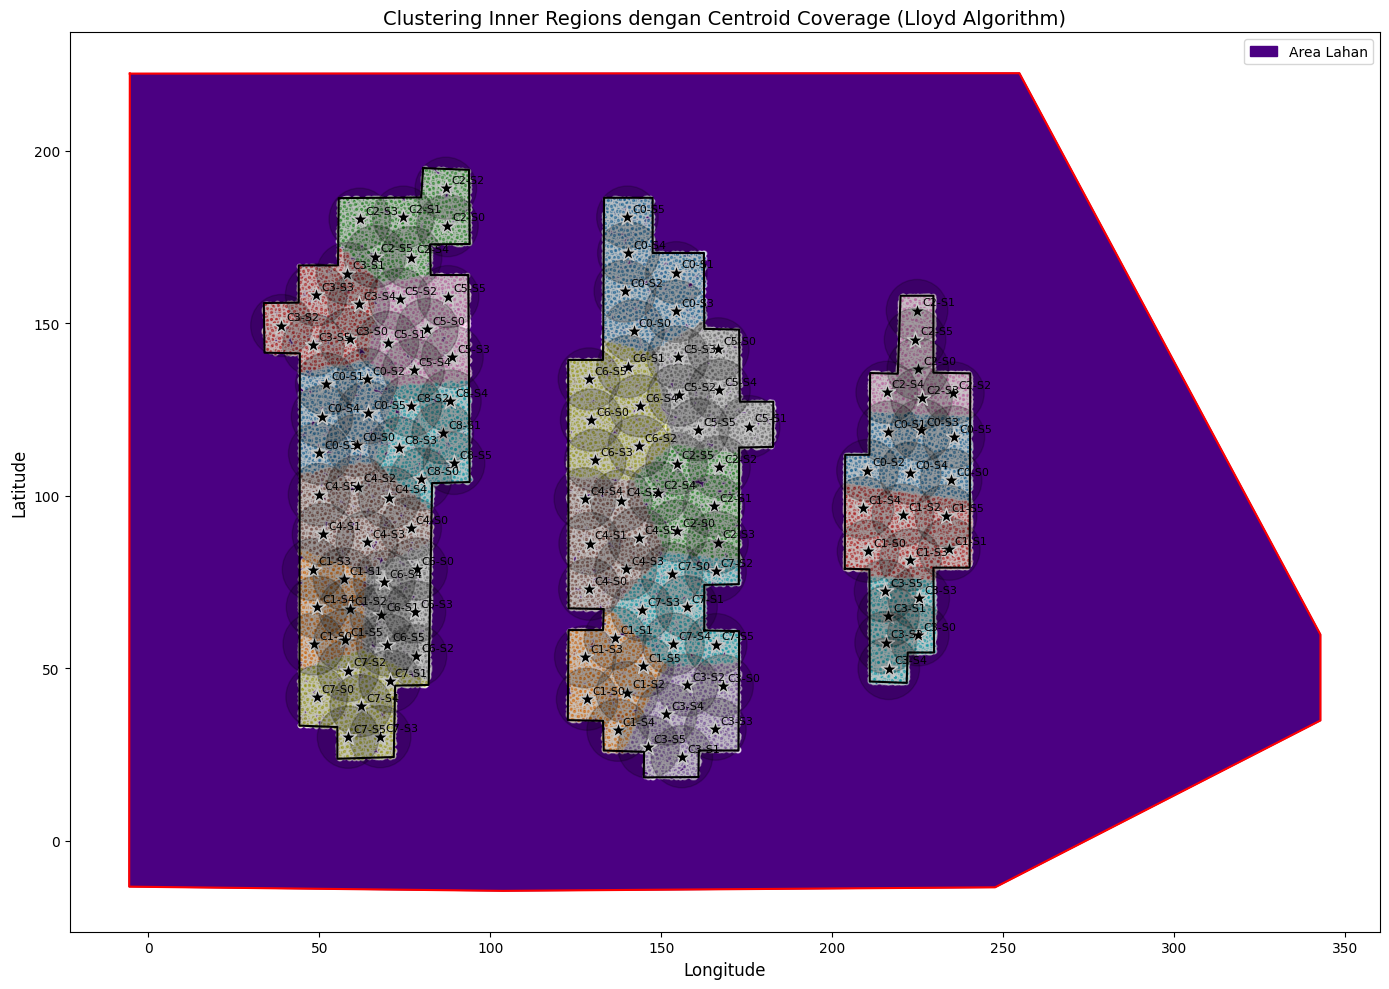

In [4]:
def plot_clusters(ax, subclusters_points, subclusters_labels, main_labels,
                  subclusters_centroids, boundaries, label_prefix,
                  centroid_main_labels=None, centroid_sub_labels=None):

    colors = plt.cm.get_cmap("tab10", len(set(main_labels)))

    # Buat mapping dari global main label → local C0, C1, ...
    unique_main_clusters = sorted(set(main_labels))
    main_cluster_local_map = {global_id: local_id for local_id, global_id in enumerate(unique_main_clusters)}

    # Plot semua titik
    for i in unique_main_clusters:
        cluster_points = subclusters_points[main_labels == i]
        subcluster_labels = subclusters_labels[main_labels == i]
        unique_sub_labels = np.unique(subcluster_labels)

        for sub_label in unique_sub_labels:
            subcluster_points = cluster_points[subcluster_labels == sub_label]
            ax.scatter(subcluster_points[:, 0], subcluster_points[:, 1],
                       color=colors(main_cluster_local_map[i]), alpha=0.6, edgecolor='w', s=10)

    # Plot centroid + lingkaran + label
    for idx, (cx, cy) in enumerate(subclusters_centroids):
        ax.scatter(cx, cy, marker='*', s=150, c='black', edgecolor='w')

        circle = plt.Circle((cx, cy), radius=9, color='black', alpha=0.2, linewidth=1, fill=True)
        ax.add_patch(circle)

        if centroid_main_labels is not None and centroid_sub_labels is not None:
            global_main = centroid_main_labels[idx]
            sub_cluster = centroid_sub_labels[idx]
            local_main = main_cluster_local_map[global_main]  # konversi ke C0 per inner
            label = f"C{local_main}-S{sub_cluster}"
        else:
            label = f"C?-S?"

        ax.text(cx + 1.5, cy + 1.5, label, fontsize=8, color='black')

# ===== VISUALISASI UTAMA =====
fig, ax = plt.subplots(figsize=(14, 10))

# Plot area lahan (outer)
ax.fill(*zip(*outer_points), color='indigo', alpha=1, label="Area Lahan")
ax.plot(*zip(*outer_points_closed), linestyle='-', color='red', linewidth=1.5)

# Plot outline inner regions
ax.plot(*zip(*inner_1_points_closed), linestyle='-', color='black', linewidth=1.5)
ax.plot(*zip(*inner_2_points_closed), linestyle='-', color='black', linewidth=1.5)
ax.plot(*zip(*inner_3_points_closed), linestyle='-', color='black', linewidth=1.5)

# Plot subclusters dan centroid per region
plot_clusters(ax, subclusters_points_1, subclusters_labels_1, main_labels_1,
              subclusters_centroids_1, boundaries_1, "Inner 1",
              centroid_main_labels=subclusters_centroid_main_labels_1,
              centroid_sub_labels=subclusters_centroid_sub_labels_1)

plot_clusters(ax, subclusters_points_2, subclusters_labels_2, main_labels_2,
              subclusters_centroids_2, boundaries_2, "Inner 2",
              centroid_main_labels=subclusters_centroid_main_labels_2,
              centroid_sub_labels=subclusters_centroid_sub_labels_2)

plot_clusters(ax, subclusters_points_3, subclusters_labels_3, main_labels_3,
              subclusters_centroids_3, boundaries_3, "Inner 3",
              centroid_main_labels=subclusters_centroid_main_labels_3,
              centroid_sub_labels=subclusters_centroid_sub_labels_3)

# Set judul dan label
ax.set_title("Clustering Inner Regions dengan Centroid Coverage (Lloyd Algorithm)", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
def compute_uav_coverage_ratio(centroids, boundary_polygon, radius):
    # Buat lingkaran coverage dari setiap centroid (buffer = radius dalam meter)
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    
    # Gabungkan semua lingkaran menjadi satu shape
    total_coverage_union = unary_union(coverage_circles)

    # Hitung area yang benar-benar berada di dalam boundary inner region
    effective_coverage = total_coverage_union.intersection(boundary_polygon)

    # Luas yang tercakup dibagi total area inner
    ratio = (effective_coverage.area / boundary_polygon.area) * 100
    return effective_coverage.area, boundary_polygon.area, ratio

radius = 9  # meter

# Coverage inner 1
covered_area_1, area_inner_1, ratio_1 = compute_uav_coverage_ratio(
    subclusters_centroids_1, inner_1_boundary, radius)

# Coverage inner 2
covered_area_2, area_inner_2, ratio_2 = compute_uav_coverage_ratio(
    subclusters_centroids_2, inner_2_boundary, radius)

# Coverage inner 3
covered_area_3, area_inner_3, ratio_3 = compute_uav_coverage_ratio(
    subclusters_centroids_3, inner_3_boundary, radius)

# Total coverage
total_covered = covered_area_1 + covered_area_2 + covered_area_3
total_inner = inner_1_boundary.area + inner_2_boundary.area + inner_3_boundary.area
total_ratio = (total_covered / total_inner) * 100

# Cetak hasil
print(f"✅ Coverage UAV Inner 1 : {covered_area_1:.2f} m² dari {area_inner_1:.2f} m² ({ratio_1:.2f}%)")
print(f"✅ Coverage UAV Inner 2 : {covered_area_2:.2f} m² dari {area_inner_2:.2f} m² ({ratio_2:.2f}%)")
print(f"✅ Coverage UAV Inner 3 : {covered_area_3:.2f} m² dari {area_inner_3:.2f} m² ({ratio_3:.2f}%)")
print(f"📊 Total UAV Coverage   : {total_covered:.2f} m² dari {total_inner:.2f} m² ({total_ratio:.2f}%)")


✅ Coverage UAV Inner 1 : 6758.25 m² dari 6764.79 m² (99.90%)
✅ Coverage UAV Inner 2 : 6843.35 m² dari 6852.79 m² (99.86%)
✅ Coverage UAV Inner 3 : 2671.47 m² dari 2671.47 m² (100.00%)
📊 Total UAV Coverage   : 16273.07 m² dari 16289.05 m² (99.90%)


In [6]:
from itertools import combinations

def compute_overlap_between_centroids(centroids, radius):
    """Menghitung total area overlap antar semua pasang coverage centroid"""
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    
    total_overlap_area = 0.0
    checked_pairs = set()
    
    # Hitung overlap untuk setiap pasangan unik
    for i, j in combinations(range(len(coverage_circles)), 2):
        circle_i = coverage_circles[i]
        circle_j = coverage_circles[j]
        if circle_i.intersects(circle_j):
            intersection = circle_i.intersection(circle_j)
            total_overlap_area += intersection.area
    
    return total_overlap_area

# Hitung total area overlapping dari semua centroid
overlap_area_1 = compute_overlap_between_centroids(subclusters_centroids_1, radius)
overlap_area_2 = compute_overlap_between_centroids(subclusters_centroids_2, radius)
overlap_area_3 = compute_overlap_between_centroids(subclusters_centroids_3, radius)

# Ringkasan
total_overlap_area = overlap_area_1 + overlap_area_2 + overlap_area_3

print(f"🔁 Overlapping Inner 1: {overlap_area_1:.2f} m²")
print(f"🔁 Overlapping Inner 2: {overlap_area_2:.2f} m²")
print(f"🔁 Overlapping Inner 3: {overlap_area_3:.2f} m²")
print(f"🔁 Total Overlapping Area: {total_overlap_area:.2f} m²")
print(f"📊 Persentase Overlap dari Total Cakupan: {(total_overlap_area / total_covered) * 100:.2f}%")
print(f"📊 Persentase Overlap dari Total Inner Area: {(total_overlap_area / total_inner) * 100:.2f}%")


🔁 Overlapping Inner 1: 7038.38 m²
🔁 Overlapping Inner 2: 4841.74 m²
🔁 Overlapping Inner 3: 3080.47 m²
🔁 Total Overlapping Area: 14960.59 m²
📊 Persentase Overlap dari Total Cakupan: 91.93%
📊 Persentase Overlap dari Total Inner Area: 91.84%


In [16]:
# Gabungkan semua centroid
all_centroids = np.vstack([
    subclusters_centroids_1,
    subclusters_centroids_2,
    subclusters_centroids_3
])

# Label klaster utama dari tiap region
main_cluster_labels = np.concatenate([
    subclusters_centroid_main_labels_1,
    subclusters_centroid_main_labels_2,
    subclusters_centroid_main_labels_3
])

# Label inner region: 1, 2, 3
inner_region_labels = np.concatenate([
    np.full(len(subclusters_centroids_1), 1),
    np.full(len(subclusters_centroids_2), 2),
    np.full(len(subclusters_centroids_3), 3)
])

# Label subklaster
subcluster_labels = np.concatenate([
    subclusters_centroid_sub_labels_1,
    subclusters_centroid_sub_labels_2,
    subclusters_centroid_sub_labels_3
])

# Buat DataFrame lengkap
df_centroids = pd.DataFrame({
    "X": all_centroids[:, 0],
    "Y": all_centroids[:, 1],
    "InnerRegion": inner_region_labels,
    "MainCluster": main_cluster_labels,
    "SubCluster": subcluster_labels
})

# Simpan ke file CSV
output_path = "Z:/Tugas Akhir/Centroids.csv"
df_centroids.to_csv(output_path, index=False)

output_path

'Z:/Tugas Akhir/Centroids.csv'

In [17]:
# Fungsi menghitung luas berdasarkan Shoelace Formula
def polygon_area(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

# Hitung luas masing-masing wilayah
outer_area = polygon_area(outer_points)
inner_1_area = polygon_area(inner_1_points)
inner_2_area = polygon_area(inner_2_points)
inner_3_area = polygon_area(inner_3_points)

# Hitung total inner dan sisa lahan
total_inner_area = inner_1_area + inner_2_area + inner_3_area
remaining_area = outer_area - total_inner_area

# Cetak hasil
print(f"Luas total lahan (outer)        : {outer_area:.2f} m²")
print(f"  - Luas Inner Region 1         : {inner_1_area:.2f} m²")
print(f"  - Luas Inner Region 2         : {inner_2_area:.2f} m²")
print(f"  - Luas Inner Region 3         : {inner_3_area:.2f} m²")
print(f"Luas total daerah stress (inner): {total_inner_area:.2f} m²")
print(f"Luas lahan sehat (sisanya)      : {remaining_area:.2f} m²")

Luas total lahan (outer)        : 72817.35 m²
  - Luas Inner Region 1         : 6764.79 m²
  - Luas Inner Region 2         : 6852.79 m²
  - Luas Inner Region 3         : 2671.47 m²
Luas total daerah stress (inner): 16289.05 m²
Luas lahan sehat (sisanya)      : 56528.29 m²


In [6]:
def plot_uncovered_area(inner_boundary, centroids, radius, title):
    from shapely.geometry import Point, Polygon
    from shapely.ops import unary_union
    import matplotlib.pyplot as plt

    # Validasi
    if not isinstance(inner_boundary, Polygon):
        print(f"[ERROR] Boundary {title} is not a Polygon.")
        return
    if inner_boundary.is_empty:
        print(f"[INFO] Boundary {title} is empty.")
        return

    # Coverage circles
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    coverage_union = unary_union(coverage_circles)
    uncovered_area = inner_boundary.difference(coverage_union)

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot inner boundary
    x_inner, y_inner = inner_boundary.exterior.xy
    ax.fill(x_inner, y_inner, facecolor='none', edgecolor='black', linewidth=1.5, label='Inner Region')

    # Plot UAV coverage
    if coverage_union.geom_type == 'Polygon':
        x_cov, y_cov = coverage_union.exterior.xy
        ax.fill(x_cov, y_cov, facecolor='blue', alpha=0.3, label='UAV Coverage')
    elif coverage_union.geom_type == 'MultiPolygon':
        for poly in coverage_union.geoms:
            x_cov, y_cov = poly.exterior.xy
            ax.fill(x_cov, y_cov, facecolor='blue', alpha=0.3)

    # Plot uncovered area (jika ada)
    if not uncovered_area.is_empty:
        if uncovered_area.geom_type == 'Polygon':
            x_uncov, y_uncov = uncovered_area.exterior.xy
            ax.fill(x_uncov, y_uncov, facecolor='red', alpha=0.4, label='Uncovered Area')
        elif uncovered_area.geom_type == 'MultiPolygon':
            for poly in uncovered_area.geoms:
                x_uncov, y_uncov = poly.exterior.xy
                ax.fill(x_uncov, y_uncov, facecolor='red', alpha=0.4)

        print(f"❗ Masih ada area tidak tercakup di {title} sebesar {uncovered_area.area:.2f} m²")
    else:
        print(f"✅ Semua area di {title} tercakup oleh UAV coverage")

    # Plot centroids
    cx, cy = zip(*centroids)
    ax.scatter(cx, cy, color='black', marker='x', label='Centroids')

    ax.set_title(f"UAV Coverage vs Uncovered Area in {title}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


❗ Masih ada area tidak tercakup di Inner Region 1 sebesar 4.03 m²


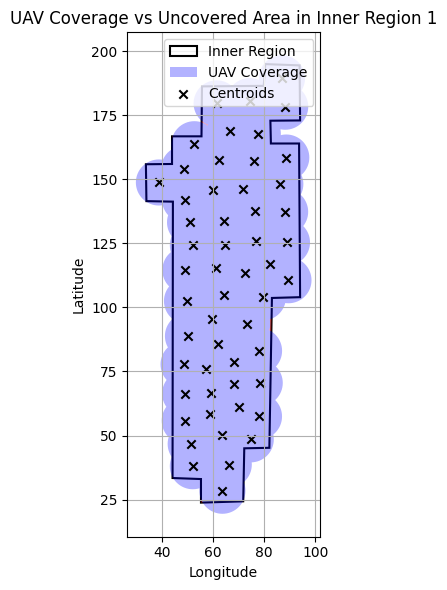

❗ Masih ada area tidak tercakup di Inner Region 2 sebesar 10.40 m²


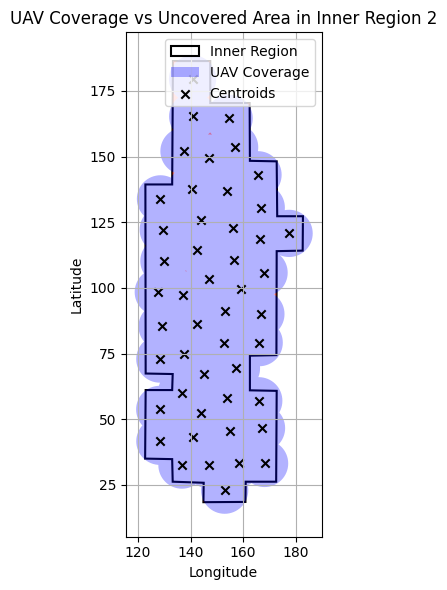

✅ Semua area di Inner Region 3 tercakup oleh UAV coverage


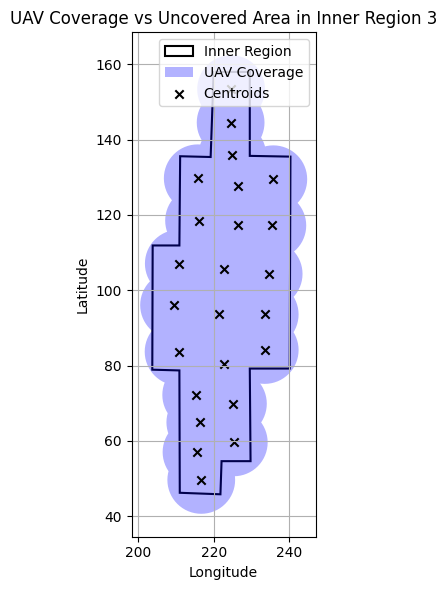

In [8]:
radius = 9  # meters

plot_uncovered_area(inner_1_boundary, subclusters_centroids_1, radius, "Inner Region 1")
plot_uncovered_area(inner_2_boundary, subclusters_centroids_2, radius, "Inner Region 2")
plot_uncovered_area(inner_3_boundary, subclusters_centroids_3, radius, "Inner Region 3")

In [7]:
def plot_all_uncovered_areas_combined(boundary_list, centroids_list, radius):
    from shapely.geometry import Point, Polygon
    from shapely.ops import unary_union
    import matplotlib.pyplot as plt

    region_colors = ['black', 'green', 'blue']
    fig, ax = plt.subplots(figsize=(14, 10))

    total_inner_area = 0
    total_uncovered_area = 0

    for idx, (boundary, centroids) in enumerate(zip(boundary_list, centroids_list)):
        region_label = f"Inner {idx+1}"

        if not isinstance(boundary, Polygon) or boundary.is_empty:
            print(f"[SKIP] {region_label} bukan Polygon valid.")
            continue

        # Hitung coverage dan uncovered
        coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
        coverage_union = unary_union(coverage_circles)
        uncovered_area = boundary.difference(coverage_union)
        covered_area = boundary.intersection(coverage_union)

        total_inner_area += boundary.area
        total_uncovered_area += uncovered_area.area

        # 1. Garis batas inner
        x_inner, y_inner = boundary.exterior.xy
        ax.plot(x_inner, y_inner, color=region_colors[idx], linewidth=2, label=f"{region_label} Boundary")

        # 2. ✅ Area yang tercakup → HIJAU transparan
        if not covered_area.is_empty:
            if covered_area.geom_type == 'Polygon':
                x_cov, y_cov = covered_area.exterior.xy
                ax.fill(x_cov, y_cov, facecolor='limegreen', alpha=0.4, label=f"Covered {region_label}")
            elif covered_area.geom_type == 'MultiPolygon':
                for poly in covered_area.geoms:
                    x_cov, y_cov = poly.exterior.xy
                    ax.fill(x_cov, y_cov, facecolor='limegreen', alpha=0.4)

        # 3. ❌ Area yang tidak tercakup → MERAH NYALA
        if not uncovered_area.is_empty:
            if uncovered_area.geom_type == 'Polygon':
                x_uncov, y_uncov = uncovered_area.exterior.xy
                ax.fill(x_uncov, y_uncov, facecolor='red', edgecolor='red',
                        linewidth=2.5, alpha=0.8, label=f"Uncovered {region_label}")
            elif uncovered_area.geom_type == 'MultiPolygon':
                for poly in uncovered_area.geoms:
                    x_uncov, y_uncov = poly.exterior.xy
                    ax.fill(x_uncov, y_uncov, facecolor='red', edgecolor='red',
                            linewidth=2.5, alpha=0.8)

        # 4. Plot Centroids
        cx, cy = zip(*centroids)
        ax.scatter(cx, cy, color='black', s=30, marker='x', label=f"{region_label} Centroids")

    # 🔢 Summary
    uncovered_pct = (total_uncovered_area / total_inner_area) * 100

    ax.set_title(f"🛰️ UAV Coverage — Green = Covered, Red = Uncovered ({uncovered_pct:.2f}%)", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='upper right', fontsize=9)
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"📏 Total inner area: {total_inner_area:.2f} m²")
    print(f"📉 Total uncovered area: {total_uncovered_area:.2f} m²")
    print(f"🧮 Persentase tidak tercakup: {uncovered_pct:.2f}%")


C:\Users\naufa\AppData\Local\Temp\ipykernel_6272\1316965439.py:67: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  plt.tight_layout()
C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


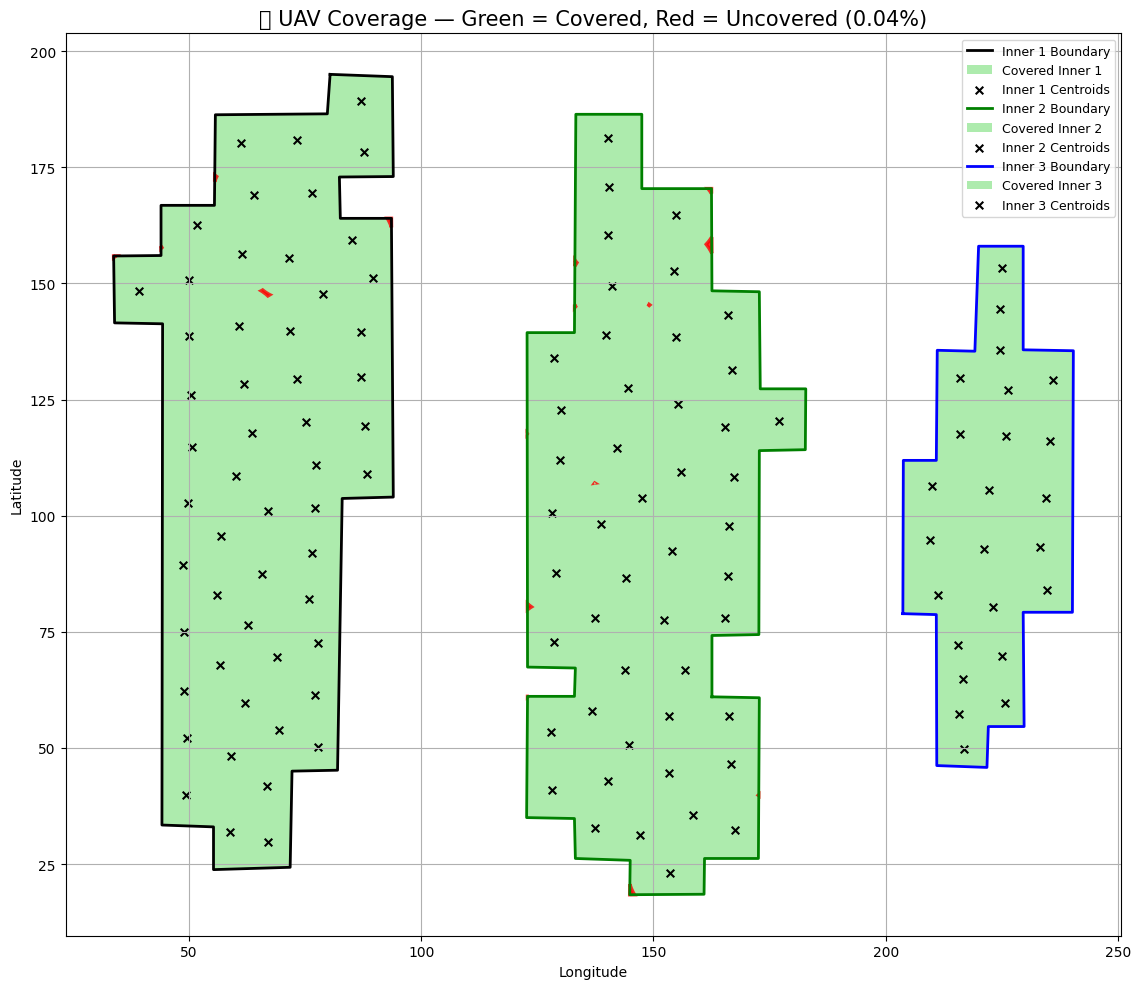

📏 Total inner area: 16289.05 m²
📉 Total uncovered area: 6.05 m²
🧮 Persentase tidak tercakup: 0.04%


In [15]:
plot_all_uncovered_areas_combined(
    [inner_1_boundary, inner_2_boundary, inner_3_boundary],
    [subclusters_centroids_1, subclusters_centroids_2, subclusters_centroids_3],
    radius=9
)